# Import Library

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
        
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

2025-09-25 13:20:04.922144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758806404.945353    3902 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758806404.952847    3902 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
data = "/kaggle/input/sibi-dataset/SIBI"

# Eksplorasi Distribusi Data

In [4]:
classes = os.listdir(data)
print("Jumlah kelas (huruf):", len(classes))
print("Daftar kelas:", classes)

Jumlah kelas (huruf): 24
Daftar kelas: ['N', 'R', 'B', 'I', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'C', 'P', 'L', 'W', 'D']


In [5]:
count_per_class = {}
for cls in classes:
    count_per_class[cls] = len(os.listdir(os.path.join(data, cls)))
    
print("Jumlah gambar per kelas:")
print(count_per_class)

Jumlah gambar per kelas:
{'N': 220, 'R': 220, 'B': 220, 'I': 220, 'F': 220, 'H': 220, 'E': 220, 'U': 220, 'M': 220, 'X': 220, 'K': 220, 'Q': 220, 'Y': 220, 'S': 220, 'G': 220, 'A': 220, 'O': 220, 'T': 220, 'V': 220, 'C': 220, 'P': 220, 'L': 220, 'W': 220, 'D': 220}


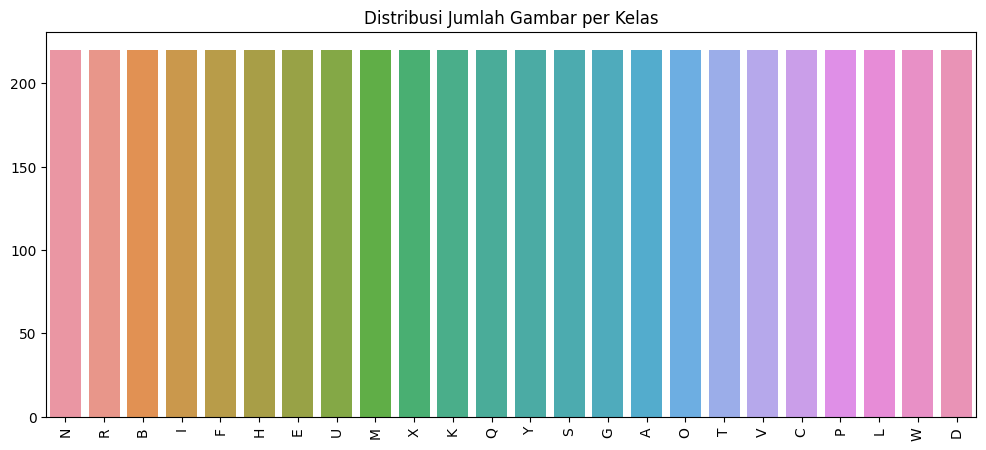

In [6]:
plt.figure(figsize=(12,5))
sns.barplot(x=list(count_per_class.keys()), y=list(count_per_class.values()))
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xticks(rotation=90)
plt.show()

# Normalisasi + Augmentasi + Split Data

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalisasi piksel [0,1]
    rotation_range=20,           # Rotasi random
    width_shift_range=0.2,       # Pergeseran horizontal
    height_shift_range=0.2,      # Pergeseran vertikal
    shear_range=0.2,             # Distorsi
    zoom_range=0.2,              # Zoom
    horizontal_flip=True,        # Flip horizontal
    brightness_range=[0.8,1.2],  # Variasi pencahayaan
    validation_split=0.2         # 20% data dipakai validasi
)

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [10]:
train_generator = train_datagen.flow_from_directory(
    data,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 4224 images belonging to 24 classes.


In [11]:
val_generator = test_datagen.flow_from_directory(
    data,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 1056 images belonging to 24 classes.


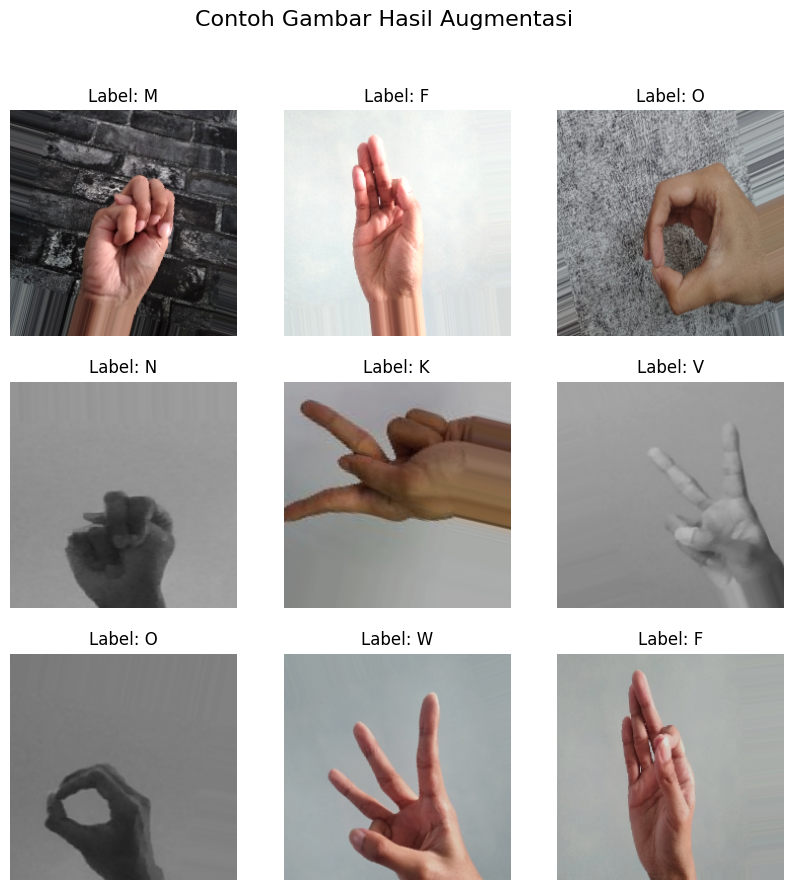

In [12]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.axis("off")
    plt.title(f"Label: {list(train_generator.class_indices.keys())[np.argmax(y_batch[i])]}")
plt.suptitle("Contoh Gambar Hasil Augmentasi", fontsize=16)
plt.show()

In [13]:
import math

total_images = sum([len(files) for r, d, files in os.walk(data)])
print("Jumlah data asli (tanpa augmentasi):", total_images)

train_steps = math.ceil(train_generator.samples / train_generator.batch_size)
val_steps = math.ceil(val_generator.samples / val_generator.batch_size)

print("Jumlah data training (asli):", train_generator.samples)
print("Jumlah data validation (asli):", val_generator.samples)

augmented_images = 0
for i in range(5):
    x_batch, y_batch = next(train_generator)
    augmented_images += x_batch.shape[0]

print("Jumlah data hasil augmentasi (contoh 5 batch):", augmented_images)

print("\n⚠️ Catatan: Augmentasi bersifat real-time. "
      "Jumlah file asli tetap, tapi setiap epoch akan menghasilkan gambar baru "
      "dengan variasi rotasi/zoom/flip, sehingga dataset jadi 'tak terbatas'.")

Jumlah data asli (tanpa augmentasi): 5280
Jumlah data training (asli): 4224
Jumlah data validation (asli): 1056
Jumlah data hasil augmentasi (contoh 5 batch): 160

⚠️ Catatan: Augmentasi bersifat real-time. Jumlah file asli tetap, tapi setiap epoch akan menghasilkan gambar baru dengan variasi rotasi/zoom/flip, sehingga dataset jadi 'tak terbatas'.


# Setup Model

In [14]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

I0000 00:00:1758806418.795541    3902 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758806418.796158    3902 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [15]:
base_model.trainable = False

In [16]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(24, activation='softmax')(x)

In [17]:
model = Model(inputs=base_model.input, outputs=preds)

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
# model.summary()

# Training Model

In [20]:
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [21]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/30


I0000 00:00:1758806431.829716    3971 service.cc:148] XLA service 0x7c405c112960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758806431.829779    3971 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758806431.829788    3971 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758806432.700773    3971 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/132 ━━━━━━━━━━━━━━━━━━━━ 31:25 14s/step - accuracy: 0.0312 - loss: 3.8904

I0000 00:00:1758806437.269307    3971 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0559 - loss: 3.5005
Epoch 1: val_accuracy improved from -inf to 0.24432, saving model to best_model.h5
132/132 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.0560 - loss: 3.4990 - val_accuracy: 0.2443 - val_loss: 2.7841 - learning_rate: 1.0000e-04
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1417 - loss: 2.9722
Epoch 2: val_accuracy improved from 0.24432 to 0.40436, saving model to best_model.h5
132/132 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.1417 - loss: 2.9719 - val_accuracy: 0.4044 - val_loss: 2.4187 - learning_rate: 1.0000e-04
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2210 - loss: 2.7021
Epoch 3: val_accuracy improved from 0.40436 to 0.49242, saving model to best_model.h5
132/132 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.2211 - loss: 2.7019 - val_accuracy: 0.4924 - val_loss: 1.9913 - learning_rate: 1.0000e-04
Epoch 4/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 

# Visualisasi Hasil Training

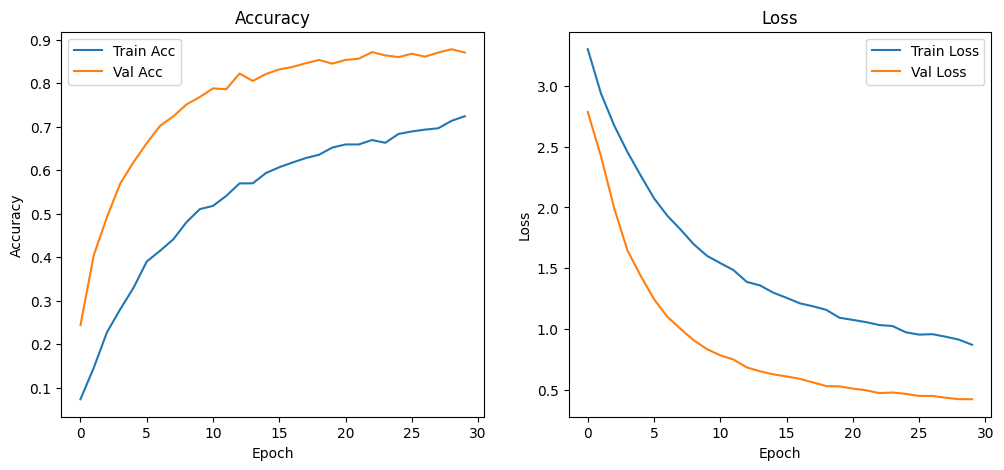

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()